Import necessary packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

from custom_functions import remove_extremes

Import dataset that was cleaned and prepared in Data Preparation notebook

In [2]:
conn = sqlite3.connect('../../data/processed/main.db')
query = '''SELECT * FROM df_main'''
df_main = pd.read_sql(query, conn)
df_main.head(3)

,index,SalePrice,Parcel_ID,PropertyType,PrincipalUse,SaleInstrument,AFForestLand,AFCurrentUseLand,AFNonProfitUse,AFHistoricProperty,SaleReason,PropertyClass,SaleWarning,porch_both,porch_none,porch_closed,porch_open,heat_FloorWall,heat_Gravity,heat_Radiant,heat_ElecBB,heat_ForcedAir,heat_HotWater,heat_HeatPump,heat_Other,NbrLivingUnits,ZipCode,Stories,BldgGrade,SqFt1stFloor,SqFtHalfFloor,SqFt2ndFloor,SqFtUpperFloor,SqFtUnfinFull,SqFtUnfinHalf,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,FinBasementGrade,SqFtGarageBasement,SqFtGarageAttached,DaylightBasement,SqFtOpenPorch,SqFtEnclosedPorch,SqFtDeck,HeatSystem,HeatSource,BrickStone,ViewUtilization,Bedrooms,BathHalfCount,Bath3qtrCount,BathFullCount,FpSingleStory,FpMultiStory,FpFreestanding,FpAdditional,YrBuilt,YrRenovated,PcntComplete,Obsolescence,PcntNetCondition,Condition
0,0,445000.0,010050-0380,11,6,3,N,N,N,N,1,8,,0,0,0,1,0,0,0,0,1,0,0,0,1,98003,1,7,1480,0,0,0,0,0,1480,0,0,0,0,440,,80,0,120,5,2,0,,3,0,0,2,1,0,0,0,1994,0,0,0,0,5
1,1,188500.0,017900-0315,11,6,3,N,N,N,N,1,8,,0,1,0,0,1,0,0,0,0,0,0,0,1,98178,1,5,550,0,0,0,0,0,550,0,0,0,0,0,,0,0,0,1,1,0,,2,0,1,0,0,0,0,0,1942,0,0,0,0,3
2,2,730000.0,018800-0095,11,6,3,N,N,N,N,1,8,,0,1,0,0,1,0,0,0,0,0,0,0,1,98102,2,9,660,0,595,0,0,0,1540,380,285,8,0,0,Y,0,0,155,1,3,0,Y,3,1,1,1,0,1,0,0,1984,0,0,0,0,3


## Model *Porch* Predictions

In [3]:
df_main.columns

Index(['index', 'SalePrice', 'Parcel_ID', 'PropertyType', 'PrincipalUse',
       'SaleInstrument', 'AFForestLand', 'AFCurrentUseLand', 'AFNonProfitUse',
       'AFHistoricProperty', 'SaleReason', 'PropertyClass', 'SaleWarning',
       'porch_both', 'porch_none', 'porch_closed', 'porch_open',
       'heat_FloorWall', 'heat_Gravity', 'heat_Radiant', 'heat_ElecBB',
       'heat_ForcedAir', 'heat_HotWater', 'heat_HeatPump', 'heat_Other',
       'NbrLivingUnits', 'ZipCode', 'Stories', 'BldgGrade', 'SqFt1stFloor',
       'SqFtHalfFloor', 'SqFt2ndFloor', 'SqFtUpperFloor', 'SqFtUnfinFull',
       'SqFtUnfinHalf', 'SqFtTotLiving', 'SqFtTotBasement', 'SqFtFinBasement',
       'FinBasementGrade', 'SqFtGarageBasement', 'SqFtGarageAttached',
       'DaylightBasement', 'SqFtOpenPorch', 'SqFtEnclosedPorch', 'SqFtDeck',
       'HeatSystem', 'HeatSource', 'BrickStone', 'ViewUtilization', 'Bedrooms',
       'BathHalfCount', 'Bath3qtrCount', 'BathFullCount', 'FpSingleStory',
       'FpMultiStory', 'FpFre

,SalePrice,SqFtOpenPorch,SqFtEnclosedPorch
SalePrice,1.000000,0.227628,-0.008176
SqFtOpenPorch,0.227628,1.000000,-0.015348
SqFtEnclosedPorch,-0.008176,-0.015348,1.000000


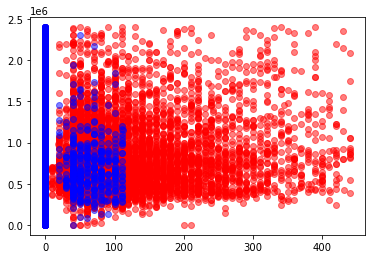

In [4]:

def remove_df_extremes(df, devct, specific_columns=False, drop_zeros=False):
    
    if specific_columns==False:
        keeper = pd.DataFrame(columns=df.columns)
    else:
        keeper = pd.DataFrame(columns=df[specific_columns].columns)
    
    for col in cols:
        keeper[col] = [float(num) for num in df[col]]
        med = keeper[col].median()
        std = keeper[col].std()

        max_ = med + devct*std
        min_ = 0.0001 if drop_zeros else med - devct*std 

        keeper[col] = [x if ((x>min_) & (x<max_)) else np.nan for x in keeper[col]]
    return keeper    

cols = ['SalePrice', 'SqFtOpenPorch', 'SqFtEnclosedPorch']
cleaned = remove_df_extremes(df_main, 3, cols, drop_zeros=False)
    

x = cleaned['SqFtOpenPorch']
y = cleaned.SalePrice
plt.scatter(x, y, color='r', alpha=0.5)
plt.scatter(cleaned['SqFtEnclosedPorch'], y, color='b', alpha=0.5)

cleaned.corr()

In [5]:
from statsmodels.formula.api import ols

outcome = ['SalePrice']
#columns = ['heat_FloorWall', 'heat_Gravity', 'heat_Radiant', 'heat_ElecBB', 'heat_HotWater', 'heat_HeatPump', 'heat_Other']

columns = ['SqFtOpenPorch', 'SqFtEnclosedPorch']

predictors = df_main[outcome+columns]
pred_sum = '+'.join(df_main[columns].columns)
formula = outcome[0] + ' ~ ' + pred_sum
model = ols(formula, predictors).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     527.7
Date:                Tue, 02 Mar 2021   Prob (F-statistic):          1.25e-222
Time:                        21:29:37   Log-Likelihood:            -2.3400e+05
No. Observations:               15953   AIC:                         4.680e+05
Df Residuals:                   15950   BIC:                         4.680e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          7.117e+05   4950.516    143.767      0.000    7.02e+05    7.21e+05
SqFtOpenPorch       990.0358     30.494     32.466      0.000     930.264    1049.808
SqFtEnclosedPorch   137.1681    116.774      1.175      0.240     -91.722     366.059
==============================================================================
Omnibus:                    19328.382   Durbin-Watson:                   1.795
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7833425.858
Skew:                           6.079   Prob(JB):                         0.00
Kurtosis:                     110.875   Cond. No.                         177.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""